In [1]:
if not "__WDSET__" in globals():
    %cd -q ..
    __WDSET__ = True

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm.auto import tqdm


from wsfr_read.config import DATA_ROOT

2023-12-18 17:08:33.524 | INFO     | wsfr_read.config:<module>:10 - DATA_ROOT is /Users/nsarang/Nimas/water-supply-forecast-rodeo-runtime/data


In [10]:
from core.datasets import *
from core.data.outlier import iqr_outliers
from core.data.feature import generate_timeseries_features, add_column_suffix

In [6]:
metadata = get_metadata().rename(columns={"area": "basins_area"})
df_train_monthly = pd.read_csv(DATA_ROOT / "train_monthly_naturalized_flow.csv")
df_test_monthly = pd.read_csv(DATA_ROOT / "test_monthly_naturalized_flow.csv")
df_train_targets = pd.read_csv(DATA_ROOT / "train.csv")
df_submission = pd.read_csv(DATA_ROOT / "submission_format.csv")

In [7]:
df_test_targets_v2 = df_test_monthly.merge(metadata, on="site_id").groupby(["site_id", "forecast_year"]).apply(
    lambda df: df[df["month"].between(df["season_start_month"], df["season_end_month"])]["volume"].sum()
).reset_index(name="volume")
df_train_targets_v2 = df_train_monthly.merge(metadata, on="site_id").groupby(["site_id", "forecast_year"]).apply(
    lambda df: df[df["month"].between(df["season_start_month"], df["season_end_month"])]["volume"].sum()
).reset_index(name="volume")

df_monthly = pd.concat((df_train_monthly, df_test_monthly))
df_targets = pd.concat((df_train_targets_v2, df_test_targets_v2)).rename(columns={"forecast_year": "year"})

# df_monthly = df_train_monthly
# df_targets = df_train_targets

# Data

In [8]:
years = df_targets["year"].unique()
# years = years[years > 1950]

ALL_ISSUE_DATES = pd.Series([datetime(year, month, 1) for year in years for month in range(1, 8)],
                            name="issue_date")
ALL_ISSUE_DATES

0     1898-01-01
1     1898-02-01
2     1898-03-01
3     1898-04-01
4     1898-05-01
         ...    
933   2023-03-01
934   2023-04-01
935   2023-05-01
936   2023-06-01
937   2023-07-01
Name: issue_date, Length: 938, dtype: datetime64[ns]

In [133]:
pdsi_dfs, snotel_dfs, cpc_dfs, cdec_dfs, grace_dfs = [[] for _ in range(5)]

for issue_date in tqdm(ALL_ISSUE_DATES):
    # pdsi_dfs.append(get_pdsi_features(issue_date, radius1_km=50, radius2_km=200).assign(issue_date=issue_date))
    snotel_dfs.append(get_snotel_features(issue_date, lookback=30).assign(issue_date=issue_date))
    cpc_dfs.append(get_cpc_data(issue_date).assign(issue_date=issue_date))
    # cdec_dfs.append(get_cdec_data(issue_date).assign(issue_date=issue_date))
    # grace_dfs.append(get_grace_features(issue_date, radius1_km=50, radius2_km=200).assign(issue_date=issue_date))

  0%|          | 0/938 [00:00<?, ?it/s]

In [16]:
teleconn_data = get_all_teleconnections_data()

# Assemble

In [17]:
dataset = (
    df_targets
    .rename(columns={"year": "forecast_year"})
    .dropna() # Cali sites are dropped
    .merge(ALL_ISSUE_DATES, left_on="forecast_year", right_on=ALL_ISSUE_DATES.dt.year)
    .merge(metadata, on="site_id", suffixes=("", "_md"))
)

In [13]:
from tqdm.auto import tqdm

tqdm.pandas()
df_monthly["date"] = df_monthly[["year", "month"]].apply(
    lambda r: datetime(r["year"], r["month"], 1), axis=1
)

volume_feats = dataset.progress_apply(
    generate_timeseries_features,
    df_b=df_monthly,
    condition=(
        "site_id == @row.site_id"
        " & date < @row.issue_date"
        " & forecast_year == @row.issue_date.year"
    ),
    date_col="date",
    feature_engineering=["volume"],
    axis=1,
)

  0%|          | 0/15568 [00:00<?, ?it/s]

/Users/nsarang/anaconda3/envs/watersupply/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nsarang/anaconda3/envs/watersupply/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


In [18]:
dataset = pd.concat(add_column_suffix(dataset, volume_feats, suffixes=("", "_vol")), axis=1)
dataset

,site_id,forecast_year,volume,issue_date,season_start_month,season_end_month,elevation,latitude,longitude,drainage_area,...,forecast_year_vol,month,site_id_vol,volume_vol,volume_autocorr,volume_ewm_mean7,volume_roll_max5,volume_roll_mean5,volume_roll_std7,year
0,animas_r_at_durango,1898,402.506,1898-01-01,4,7,6502.0,37.27917,-107.88034,701.0,...,1898.0,12.0,animas_r_at_durango,21.521,NaN,40.681270,85.111,46.512667,33.908377,1897.0
1,animas_r_at_durango,1898,402.506,1898-02-01,4,7,6502.0,37.27917,-107.88034,701.0,...,1898.0,1.0,animas_r_at_durango,15.372,0.983085,31.425309,85.111,38.727500,31.764036,1898.0
2,animas_r_at_durango,1898,402.506,1898-03-01,4,7,6502.0,37.27917,-107.88034,701.0,...,1898.0,2.0,animas_r_at_durango,14.828,0.987154,25.984962,85.111,33.947600,29.511908,1898.0
3,animas_r_at_durango,1898,402.506,1898-04-01,4,7,6502.0,37.27917,-107.88034,701.0,...,1898.0,3.0,animas_r_at_durango,18.815,0.962356,23.804373,32.906,20.688400,27.109557,1898.0
4,animas_r_at_durango,1898,402.506,1898-05-01,4,7,6502.0,37.27917,-107.88034,701.0,...,1898.0,4.0,animas_r_at_durango,89.871,-0.009529,42.865365,89.871,32.081400,33.172616,1898.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15563,ruedi_reservoir_inflow,2023,113.949,2023-03-01,4,7,7766.0,39.36139,-106.81861,223.0,...,2023.0,2.0,ruedi_reservoir_inflow,2.175,0.758816,2.566790,3.867,2.753800,0.650919,2023.0
15564,ruedi_reservoir_inflow,2023,113.949,2023-04-01,4,7,7766.0,39.36139,-106.81861,223.0,...,2023.0,3.0,ruedi_reservoir_inflow,2.744,0.292669,2.620685,2.744,2.529200,0.582213,2023.0
15565,ruedi_reservoir_inflow,2023,113.949,2023-05-01,4,7,7766.0,39.36139,-106.81861,223.0,...,2023.0,4.0,ruedi_reservoir_inflow,8.152,0.018773,4.216534,8.152,3.619400,2.109013,2023.0
15566,ruedi_reservoir_inflow,2023,113.949,2023-06-01,4,7,7766.0,39.36139,-106.81861,223.0,...,2023.0,5.0,ruedi_reservoir_inflow,50.048,0.961453,16.949094,50.048,13.120400,17.731436,2023.0


In [135]:
dataset = (
    dataset
    # .merge(pd.concat(snotel_dfs), on=["site_id", "issue_date"], how="left")
    # .merge(pd.concat(cpc_dfs), on=["site_id", "issue_date"], how="left")
    .merge(pd.concat(pdsi_dfs), on=["site_id", "issue_date"], how="left")
    .merge(pd.concat(cdec_dfs), on=["site_id", "issue_date"], how="left")
    .merge(pd.concat(grace_dfs), on=["site_id", "issue_date"], how="left")
)

/var/folders/82/fzhpp7ms69z7vwftg5hgy9j80000gn/T/ipykernel_55760/1501214650.py:5: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/var/folders/82/fzhpp7ms69z7vwftg5hgy9j80000gn/T/ipykernel_55760/1501214650.py:6: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [20]:
feature_engineering = {
    # "MJO": ["INDEX_2", "INDEX_5"], # ...
    "PDO": ["pdo_index"],
    # "NINO": ["NINO3.4 ANOM", "NINO3 ANOM", "NINO4"], # ...
    "ONI": ["ANOM"], # TOTAL
    "PNA": ["pna_index"],
    "SOI": ["soi"]
}

feature_suffixes = ["_roll_std7",
                    "_roll_mean5",
                    "_ewm_mean7",
                    "_autocorr",
                    "_roll_max5"]

In [21]:
for name, df_dataset in teleconn_data.items():
    print(name)
    df_feats = dataset.progress_apply(
        generate_timeseries_features,
        df_b=df_dataset,
        condition=("date < @row.issue_date"),
        date_col="date",
        feature_engineering=feature_engineering.get(name, []),
        axis=1,
    )
    dataset = pd.concat(
        add_column_suffix(dataset, df_feats, suffixes=("", "_" + name.lower())), axis=1
    )

MJO


  0%|          | 0/15568 [00:00<?, ?it/s]

NINO


  0%|          | 0/15568 [00:00<?, ?it/s]

ONI


  0%|          | 0/15568 [00:00<?, ?it/s]

PDO


  0%|          | 0/15568 [00:00<?, ?it/s]

PNA


  0%|          | 0/15568 [00:00<?, ?it/s]

SOI


  0%|          | 0/15568 [00:00<?, ?it/s]

# Split

In [22]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split

In [136]:
dataset_orig = dataset.copy()

In [137]:
len(dataset_orig)

15568

In [173]:
dataset = dataset_orig[dataset_orig["forecast_year"] > 1950].copy()
dataset = dataset[dataset["issue_date"].dt.month == 5]
dataset = dataset[dataset["volume"] > 0]
# dataset = dataset_orig.copy()
# dataset = dataset.query("site_id == 'libby_reservoir_inflow' | site_id == 'snake_r_nr_heise'")

In [174]:
X, y = (
    dataset[
        [
            "site_id",
            "basins_area",
            "elevation",
            "latitude",
            "longitude",
            # "drainage_area",
            # "volume_10",
            # "volume_11",
            # "volume_12",
            # "volume_1",
        ]
        # + [f"INDEX_{i + 1}" for i in range(10)] # MJO
        # + ['NINO1+2', 'NINO1+2 ANOM', 'NINO3', 'NINO3 ANOM', 'NINO4',
        #    'NINO4 ANOM', 'NINO3.4', 'NINO3.4 ANOM'] # NINO
        + ["TOTAL", "ANOM"]  # ONI
        + ["pdo_index", "pna_index", "soi"] # PDO PNA SOI
        + [
            "PREC_DAILY",
            "SNWD_DAILY",
            "WTEQ_DAILY",
        ]  # + ['TAVG_DAILY', 'TMAX_DAILY', 'TMIN_DAILY']
        + ["INDEX_2", "NINO1+2 ANOM", "NINO4"]  # + "INDEX_5"
        # + ["pdsi_1", "pdsi_2"]
        # + ["precip_score", "temp_mean"] # + ["precip_sd", "temp_sd"]
        # + ['SNOW DP', 'SNOW WC', 'RAIN', 'TEMP AV']
        # + ["gws_inst_1", "rtzsm_inst_1", "sfsm_inst_1",	"gws_inst_2", "rtzsm_inst_2", "sfsm_inst_2"]
        + [c + suffix for c in sum(feature_engineering.values(), []) for suffix in feature_suffixes]  
    ].copy(),
    dataset["volume"].copy(),
)


X["V"] = dataset.loc[X.index]["volume_roll_mean5"] / (X["basins_area"].values ** 2)
X["month"] = dataset.loc[X.index]["issue_date"].dt.month

elim_feats = ['pdo_index_autocorr',
 'pna_index_roll_mean5',
 'pna_index_roll_max5',
 'soi_autocorr',
 'soi_roll_std7',
 'pna_index_ewm_mean7',
 'TOTAL',
 'NINO1+2 ANOM',
 'SNWD_DAILY',
#  'ANOM',
 'ANOM_roll_std7',
 'pdo_index_roll_max5',
 'ANOM_roll_max5',
 'pdo_index',
 'pna_index_autocorr',
 'pna_index_roll_std7',
 'INDEX_2',
 'ANOM_ewm_mean7'
 ]

X = X[X.columns.difference(elim_feats)]
# X = X[X.columns[[0] + summary["selected_features"]]]


is_test = ~dataset["forecast_year"].isin(df_train_targets["year"]).to_numpy()
X_test = X[is_test].copy()
y_test = y[is_test].copy()
X = X[~is_test].copy()
y = y[~is_test].copy()


site_codes = dataset.loc[X.index]["site_id"].astype("category").cat.codes

# FY WEIGHT
start_year = 2000
fy_weight = np.full(len(X), 1)
fy_weight[dataset.loc[X.index]["forecast_year"] >= start_year] = (
    2
    * dataset.loc[X.index]["forecast_year"].nunique()
    / (dataset.loc[X.index]["forecast_year"].unique() >= start_year).sum()
)

instance_weight = dataset.loc[X.index]["basins_area"].values
instance_weight = 1 + 4 * (instance_weight - instance_weight.min()) / (instance_weight.max() - instance_weight.min())
# instance_weight = np.full(len(dataset), 1)

combined_weight = fy_weight * instance_weight
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=site_codes, random_state=None)

In [175]:
group_codes = (
    (
        dataset.loc[X.index]["site_id"]
        + "_"
        + (dataset.loc[X.index]["issue_date"].dt.year // 20).astype("str")
    )
    .astype("category")
    .cat.codes
)

# Train

In [176]:
custom_feature_weights = {
    "site_id": 1,
    # "elevation": 1,
    # "V": 1,
}

feature_weights = np.full(X.shape[1], 1.0)
for k, v in custom_feature_weights.items():
    feature_weights[X.columns.get_loc(k)] = v


default_model_params = dict(
    # n_estimators=1000,
    learning_rate=0.03,
    depth=8,
    colsample_bylevel=0.6,
    subsample=0.66,
    l2_leaf_reg=0,
    random_strength=0.5,
    # loss_function="MAE",
    feature_weights=feature_weights,
    silent=True,
)

In [177]:
from core.objectives.rmq import RmseQuantilieObjective, RmseQuantilieMetric
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from collections import defaultdict
from core.data.preprocess import DataPrep

mql_loss = lambda *args, weight, alpha=0.5: 2 * np.average(pinball_loss(*args, alpha=alpha), weights=weight)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
sgkfold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1234)
logs = defaultdict(list)

def pinball_loss(y_true, y_pred, alpha=0.5):
    diff = y_true - y_pred
    sign = (diff >= 0).astype(diff.dtype)
    loss = alpha * sign * diff - (1 - alpha) * (1 - sign) * diff
    return loss

for idx, (train_index, test_index) in enumerate(sgkfold.split(X, site_codes, group_codes)):
    # X_train, X_val = X.iloc[train_index].copy(), X.iloc[test_index].copy()
    # y_train, y_val = y.iloc[train_index].copy(), y.iloc[test_index].copy()
    X_train, X_val = X.iloc[train_index].copy(), X_test.copy()
    y_train, y_val = y.iloc[train_index].copy(), y_test.copy()
    weight_train, weight_val = combined_weight[train_index].copy(), combined_weight[test_index].copy()
    weight_val = np.full(len(X_val), 1)

    data_processor = DataPrep(target_norm=None, v_norm=None)
    data_processor.preprocess_fit(X_train, y_train)
    X_train, y_train, weight_train = data_processor.preprocess_transform(X_train, y_train, weight_train, mode="train")
    X_val, y_val, weight_val = data_processor.preprocess_transform(X_val, y_val, weight_val, mode="val")

    models = [
        # cb.CatBoostRegressor(**default_model_params, loss_function='MAE'),
        cb.CatBoostRegressor(**default_model_params, loss_function=RmseQuantilieObjective(quantile=0.5), eval_metric=RmseQuantilieMetric(quantile=0.5)),
        # cb.CatBoostRegressor(**default_model_params, loss_function='Quantile:alpha=0.1'),
        # cb.CatBoostRegressor(**default_model_params, loss_function='Quantile:alpha=0.9'),
    ]

    train_pool = cb.Pool(X_train, y_train, weight=weight_train, cat_features=["site_id", "month"])
    val_pool = cb.Pool(X_val, y_val, weight=weight_val, cat_features=["site_id", "month"])

    for m in models:
        m.fit(train_pool, eval_set=[train_pool, val_pool], early_stopping_rounds=100)
    
    y_train_pred = np.array([m.predict(X_train) for m in models])
    y_val_pred = np.array([m.predict(X_val) for m in models])

    y_train_pred = data_processor.postprocess_transform(X_train, y_train_pred)
    y_val_pred = data_processor.postprocess_transform(X_val, y_val_pred)

    logs["train_index"].append(X_train.index)
    logs["val_index"].append(X_val.index)
    logs["train_pred"].append(y_train_pred)
    logs["val_pred"].append(y_val_pred)
    logs["data_processor"] += [data_processor]


train_loc = np.concatenate(logs["train_index"])
val_loc = np.concatenate(logs["val_index"])
y_pred_train = np.concatenate(logs["train_pred"], axis=1)
y_pred_val = np.concatenate(logs["val_pred"], axis=1)

train_index = X.index.get_indexer_for(train_loc)
val_index = X_test.index.get_indexer_for(val_loc)

y_all = y.to_numpy()
y_gt_train = y_all[train_index]
# y_gt_val = y_all[val_index]
y_gt_val = y_test.to_numpy()[val_index]
fy_weight_train = fy_weight[train_index]
# fy_weight_val = fy_weight[val_index]
fy_weight_val = np.full(len(val_index), 1)

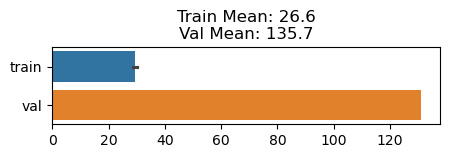

In [178]:
# error_train = 2 * pinball_loss(y_gt_train, y_pred_train[0], alpha=0.5)
# error_val = 2 * pinball_loss(y_gt_val, y_pred_val[0], alpha=0.5)


quantiles = [0.5]
# quantiles = [0.5, 0.1, 0.9]

error_train = 2 * np.stack([pinball_loss(y_gt_train, y_pred_train[i], alpha=q) for i, q in enumerate(quantiles)], axis=1).mean(axis=1)
error_val = 2 * np.stack([pinball_loss(y_gt_val, y_pred_val[i], alpha=q) for i, q in enumerate(quantiles)], axis=1).mean(axis=1)

train_lengths = np.cumsum([0] + list(map(len, logs["train_index"])))
val_lengths = np.cumsum([0] + list(map(len, logs["val_index"])))


error_train_folds = np.array(
    [
        np.average(error_train[train_index[l:r]], weights=fy_weight_train[train_index[l:r]])
        for l, r in zip(train_lengths[:-1], train_lengths[1:])
    ]
)
error_val_folds = np.array(
    [
        np.average(error_val[val_index[l:r]], weights=fy_weight_val[val_index[l:r]])
        for l, r in zip(val_lengths[:-1], val_lengths[1:])
    ]
)

plt.figure(figsize=(5, 1))
sns.barplot(pd.DataFrame({"train": error_train_folds, "val": error_val_folds}), orient="h")
plt.title(
    # f"Results\n"
    f"Train Mean: {np.average(error_train, weights=fy_weight_train):.1f}\n"
    f"Val Mean: {np.average(error_val, weights=fy_weight_val):.1f}"
);

In [ ]:
# m = models[0]

# X_test_, _, _ = data_processor.preprocess_transform(X_test, y_test, weight_val, mode="val")
# y_pred = m.predict(X_test_)
# y_pred_ = data_processor.postprocess_transform(X_test_, y_pred) 
# 2 * pinball_loss(y_test, y_pred_, alpha=0.5).mean()

df_viz = dataset[is_test].copy()
df_viz["target"] = y_test
df_viz["pred"] = y_pred_

px.line(df_viz, x="forecast_year", y=["target", "pred"], color="site_id")


In [103]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# X, y = make_regression(n_samples=1000, n_features=100, n_informative=20, random_state=0)
# train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)
# feature_names = ['F{}'.format(i) for i in range(train_X.shape[1])]
# train_pool = Pool(train_X, train_y, feature_names=feature_names)
# test_pool = Pool(test_X, test_y, feature_names=feature_names)


model = CatBoostRegressor(**{k:v for k,v in default_model_params.items() if k != "feature_weights"})
summary = model.select_features(
    train_pool,
    eval_set=val_pool,
    features_for_select=X_train.columns,
    num_features_to_select=20,
    steps=10,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [107]:
summary["eliminated_features_names"]

['pdo_index_autocorr',
 'pna_index_roll_mean5',
 'pna_index_roll_max5',
 'soi_autocorr',
 'soi_roll_std7',
 'pna_index_ewm_mean7',
 'TOTAL',
 'NINO1+2 ANOM',
 'SNWD_DAILY',
 'ANOM',
 'ANOM_roll_std7',
 'pdo_index_roll_max5',
 'ANOM_roll_max5',
 'pdo_index',
 'pna_index_autocorr',
 'pna_index_roll_std7',
 'INDEX_2',
 'ANOM_ewm_mean7']

In [ ]:
# plt.figure(0)
# plt.hist(y_val)
# plt.figure(1)
# plt.hist(y_train)

In [446]:
masked = ~X.index.isin(X.iloc[train_index].index)
dataset[masked]
y[masked]

ValueError: Item wrong length 1402 instead of 1632.

136.02692884733887

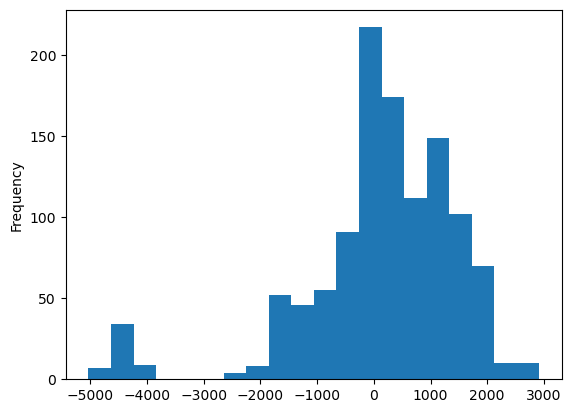

In [439]:
diff = y_gt_val - y_pred_val[0]
# diff = y_gt_train - y_pred_train
pd.Series(diff).plot.hist(bins=20)
diff.mean()

In [444]:
val_index

array([  0,   1,   2, ..., 227, 228, 229])

In [448]:
X_data = dataset.loc[val_loc, ~dataset.columns.duplicated(keep="first")].copy()
X_data["error"] = np.abs(diff)
X_data["error_normal"] = X_data["error"] / X_data["basins_area"]
X_data["diff"] = diff
X_data["pred"] = y_pred_val[0]

In [449]:
X_data.groupby("site_id")["error"].mean().sort_values(ascending=False)

site_id
libby_reservoir_inflow            4404.010162
green_r_bl_howard_a_hanson_dam    1720.338951
snake_r_nr_heise                  1566.300534
dillon_reservoir_inflow           1494.315059
taylor_park_reservoir_inflow      1487.433023
missouri_r_at_toston              1309.098561
sweetwater_r_nr_alcova            1255.640393
owyhee_r_bl_owyhee_dam            1226.836792
colville_r_at_kettle_falls        1150.190296
pecos_r_nr_pecos                  1094.142470
boise_r_nr_boise                   968.163498
skagit_ross_reservoir              923.861387
stehekin_r_at_stehekin             879.918622
hungry_horse_reservoir_inflow      773.305541
boysen_reservoir_inflow            684.856927
yampa_r_nr_maybell                 526.414310
fontenelle_reservoir_inflow        420.807613
weber_r_nr_oakley                  269.586213
virgin_r_at_virtin                 242.362975
animas_r_at_durango                134.059949
detroit_lake_inflow                110.969182
pueblo_reservoir_inflow   

In [450]:
X_data.groupby("site_id")["error_normal"].mean().sort_values(ascending=False)

site_id
green_r_bl_howard_a_hanson_dam    7.776106
pecos_r_nr_pecos                  6.367253
taylor_park_reservoir_inflow      5.846483
dillon_reservoir_inflow           4.549888
stehekin_r_at_stehekin            2.752636
weber_r_nr_oakley                 1.659717
skagit_ross_reservoir             1.153747
colville_r_at_kettle_falls        1.058863
sweetwater_r_nr_alcova            0.528184
libby_reservoir_inflow            0.487684
hungry_horse_reservoir_inflow     0.459814
boise_r_nr_boise                  0.360268
snake_r_nr_heise                  0.273857
virgin_r_at_virtin                0.255647
detroit_lake_inflow               0.245299
animas_r_at_durango               0.191268
ruedi_reservoir_inflow            0.161693
yampa_r_nr_maybell                0.155667
owyhee_r_bl_owyhee_dam            0.105219
fontenelle_reservoir_inflow       0.100213
missouri_r_at_toston              0.089199
boysen_reservoir_inflow           0.088867
pueblo_reservoir_inflow           0.021581
Nam

In [733]:
X_data.groupby("site_id")["diff"].mean().sort_values(ascending=False)

site_id
yampa_r_nr_maybell                82.241405
snake_r_nr_heise                  69.442331
missouri_r_at_toston              61.111874
hungry_horse_reservoir_inflow     54.686609
skagit_ross_reservoir             53.837095
stehekin_r_at_stehekin            27.813511
fontenelle_reservoir_inflow       18.240037
animas_r_at_durango               12.174038
ruedi_reservoir_inflow             6.734398
taylor_park_reservoir_inflow       4.513516
weber_r_nr_oakley                  2.630947
green_r_bl_howard_a_hanson_dam    -0.663306
pecos_r_nr_pecos                  -1.169222
detroit_lake_inflow               -1.450298
dillon_reservoir_inflow           -5.240732
virgin_r_at_virtin               -16.672897
boise_r_nr_boise                 -19.904043
colville_r_at_kettle_falls       -28.050781
sweetwater_r_nr_alcova           -35.956234
pueblo_reservoir_inflow          -39.955045
owyhee_r_bl_owyhee_dam           -50.737229
boysen_reservoir_inflow          -88.402271
libby_reservoir_inflow  

In [615]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 100)

In [616]:
# px.line(
#     X_data[
#         X_data["site_id"].isin(["libby_reservoir_inflow", "snake_r_nr_heise", "snake_r_nr_heise"])
#     ].sort_values(["site_id", "forecast_year"], ascending=True),
#     x="forecast_year",
#     y="V",
#     color="site_id",
# )

In [617]:
import plotly.express as px

px.line(
    X_data[
        X_data["site_id"].isin(['american_river_folsom_lake',
                                'san_joaquin_river_millerton_reservoir',
                                'merced_river_yosemite_at_pohono_bridge'])
    ].sort_values(["site_id", "forecast_year"], ascending=True),
    x="forecast_year",
    y=["pred", "volume"],
    color="site_id",
)

In [618]:
import plotly.express as px

px.line(
    X_data[
        X_data["site_id"].isin(["libby_reservoir_inflow", "snake_r_nr_heise", "owyhee_r_bl_owyhee_dam"])
    ].sort_values(["site_id", "forecast_year"], ascending=True),
    x="forecast_year",
    y=["pred", "volume"],
    color="site_id",
)

In [619]:
X_data[X_data["site_id"].isin(["libby_reservoir_inflow", "snake_r_nr_heise", "snake_r_nr_heise"])].sort_values("date", ascending=False)

,site_id,forecast_year,volume,volume_1,volume_10,volume_11,volume_12,season_start_month,season_end_month,elevation,...,TOTAL,ANOM,year,month,pdo_index,soi,pna_index,error,diff,pred
190,snake_r_nr_heise,2022,2389.842,149.641,204.865,170.421,158.188,4,7,5015.0,...,25.76,-0.92,2021,12,-2.71,1.5,-2.56,325.984875,-325.984875,2715.826875
624,libby_reservoir_inflow,2022,6230.893,253.247,293.275,469.521,578.023,4,7,2100.0,...,25.76,-0.92,2021,12,-2.71,1.5,-2.56,62.140614,-62.140614,6293.033614
623,libby_reservoir_inflow,2020,5799.534,178.109,303.837,208.181,223.556,4,7,2100.0,...,25.40,-1.27,2019,12,0.00,-0.6,0.18,898.228782,898.228782,4901.305218
189,snake_r_nr_heise,2020,3430.482,187.452,247.894,191.463,186.380,4,7,5015.0,...,25.40,-1.27,2019,12,0.00,-0.6,0.18,675.257694,675.257694,2755.224306
188,snake_r_nr_heise,2018,4257.072,224.620,297.101,294.082,241.901,4,7,5015.0,...,27.57,0.90,2017,12,-0.02,-0.1,0.89,702.647875,702.647875,3554.424125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,libby_reservoir_inflow,1969,7363.000,196.000,410.000,328.000,219.000,4,7,2100.0,...,27.14,0.81,1968,12,-0.29,0.2,-1.44,1638.820688,1638.820688,5724.179312
582,libby_reservoir_inflow,1971,6939.000,172.000,280.000,201.000,176.000,4,7,2100.0,...,25.46,-0.96,1970,12,-0.91,1.9,-0.79,629.982226,629.982226,6309.017774
583,libby_reservoir_inflow,1972,7992.363,154.314,292.760,237.025,170.579,4,7,2100.0,...,28.51,2.09,1971,12,-1.77,0.3,-1.46,1906.285232,1906.285232,6086.077768
588,libby_reservoir_inflow,1977,3027.357,166.646,348.041,247.754,208.992,4,7,2100.0,...,27.27,0.81,1976,12,1.20,-0.3,0.51,146.634211,146.634211,2880.722789


# Feature Imp

In [179]:
catboost_model = models[0]

In [180]:
feat_imp = catboost_model.get_feature_importance(
            type=cb.EFstrType.PredictionValuesChange,
            data=val_pool
        )

pd.DataFrame(
        feat_imp[None, :],
        columns=X.columns
) / feat_imp[0]

,ANOM,ANOM_autocorr,ANOM_roll_mean5,NINO4,PREC_DAILY,V,WTEQ_DAILY,basins_area,elevation,latitude,...,month,pdo_index_ewm_mean7,pdo_index_roll_mean5,pdo_index_roll_std7,pna_index,site_id,soi,soi_ewm_mean7,soi_roll_max5,soi_roll_mean5
0,1.0,0.51092,0.483128,0.412606,1.671789,3.965531,3.738885,16.969806,6.591243,10.511929,...,0.0,0.378923,0.833899,0.806476,0.514642,11.614321,0.451888,0.535482,0.163004,0.569727


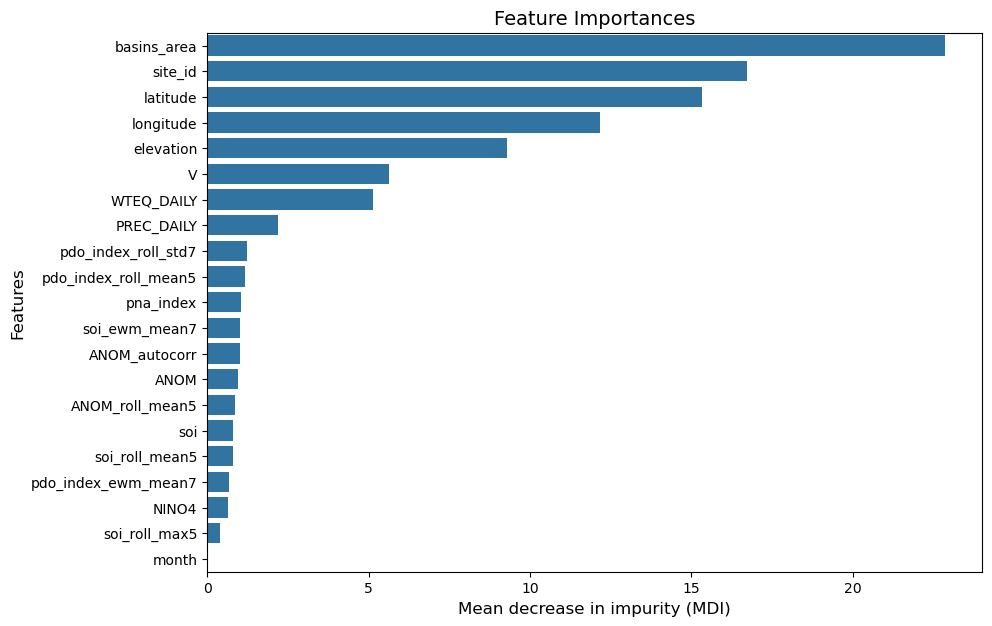

In [181]:
from core.utils import plot_feature_importance

features = X.columns
importance = catboost_model.get_feature_importance()
plot_feature_importance(features, importance);

In [263]:
import shap
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(catboost_model)
shap_values = explainer(X_val)

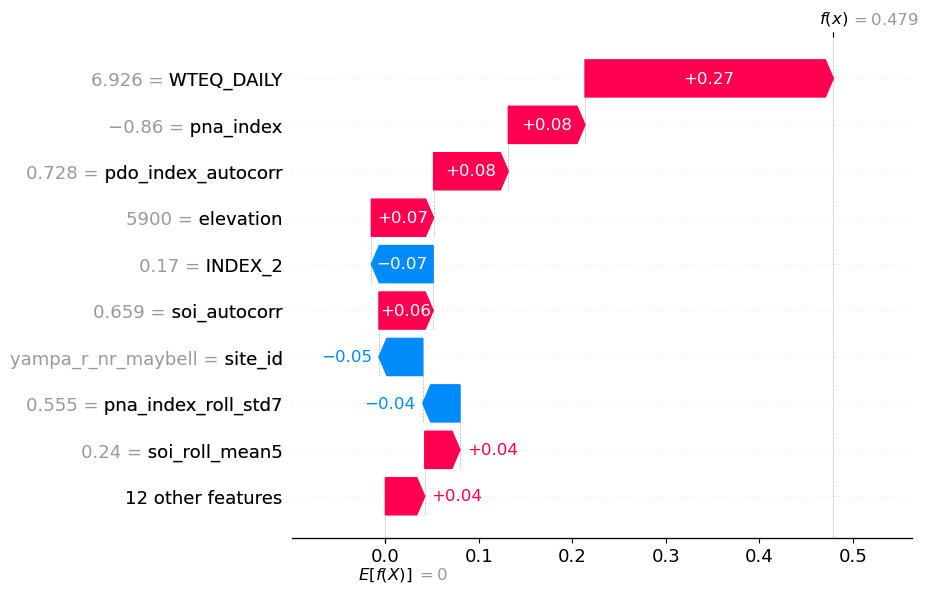

In [264]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[120])

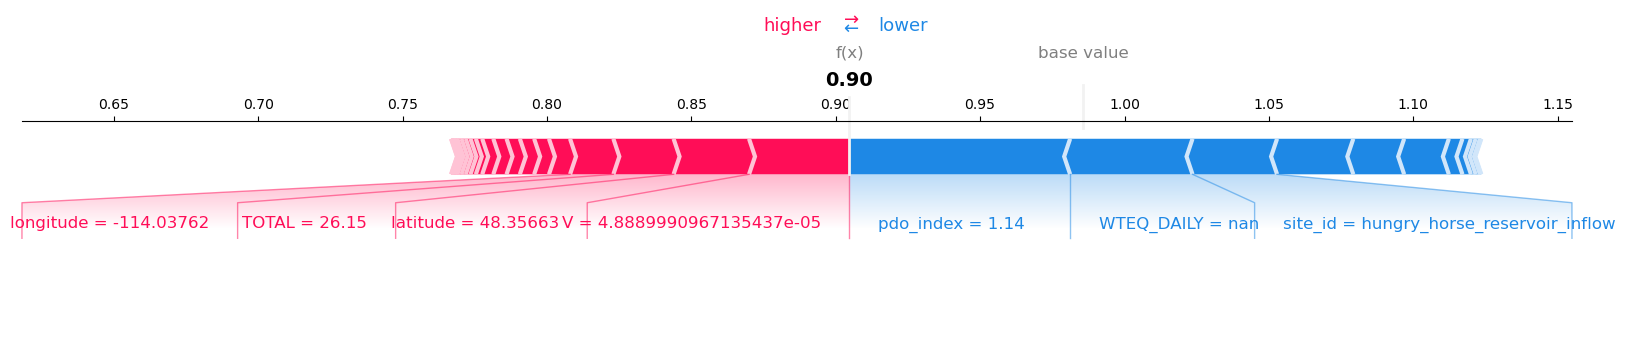

In [151]:
# shap.initjs()
shap.plots.force(shap_values[0], matplotlib=True)

In [48]:
shap.plots.force(shap_values, matplotlib=True)

NotImplementedError: matplotlib = True is not yet supported for force plots with multiple samples!

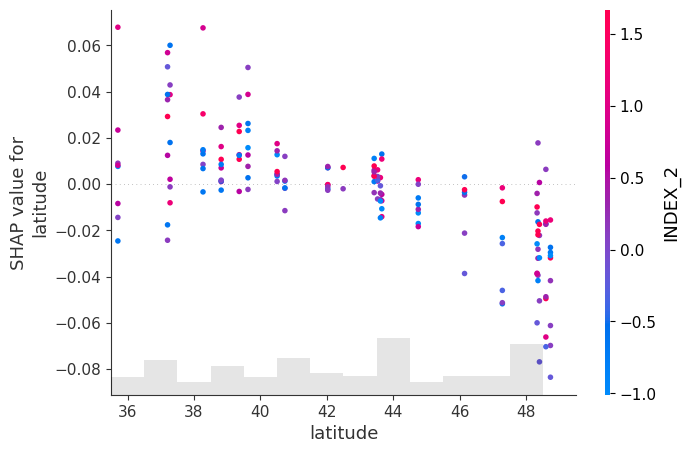

In [49]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "latitude"], color=shap_values)

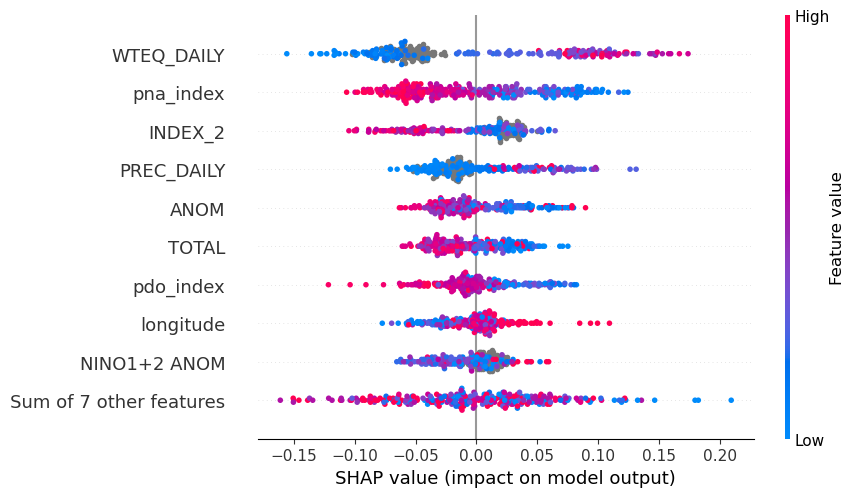

In [50]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

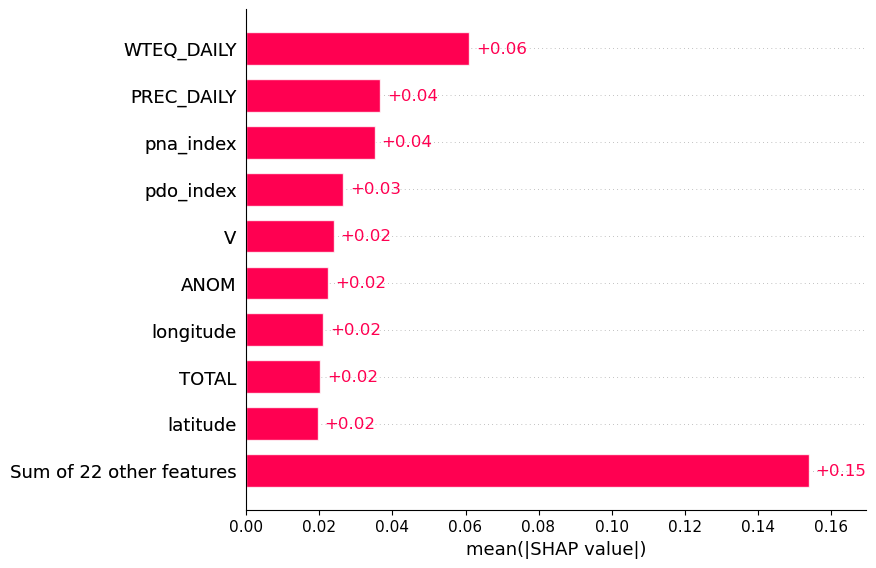

In [154]:
shap.plots.bar(shap_values)

In [155]:
catboost_model.base_models

AttributeError: 'CatBoostRegressor' object has no attribute 'base_models'

In [158]:
# shap.TreeExplainer(catboost_model).shap_interaction_values(X)

In [665]:
import cdsapi
c = cdsapi.Client(
    url="https://cds.climate.copernicus.eu/api/v2",
    key="275276:19c84c47-6d85-49ef-9fdd-34b9268e9d6e"
)
# Define your data request parameters
request_params = {
    'product_type': 'monthly_mean',  # Change this as needed
    'format': 'grib',               # Data format (e.g., 'grib', 'netcdf')
    'variable': '2m_temperature',   # Change this to the variable you want
    'year': '2020',                 # Specify the year
    'month': ['01', '02', '03'],    # Specify months
    'day': ['01', '15', '31'],      # Specify days
    'time': '12:00',                # Specify time (for subdaily data)
    'leadtime_hour': ['24', '48', '72'],  # Lead time hours
}

# Download the data
c.retrieve(
    'seasonal-original-single-levels',  # This is the dataset identifier
    request_params,
    'downloaded_data.grib'              # Output filename
)

2023-12-16 00:31:06,785 INFO Welcome to the CDS
2023-12-16 00:31:06,786 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-original-single-levels
2023-12-16 00:31:07,002 INFO Request is queued
2023-12-16 00:31:08,185 INFO Request is running
2023-12-16 00:31:57,718 INFO Request is failed
2023-12-16 00:31:57,732 ERROR Message: Killed by system admin due to internal issue
2023-12-16 00:31:57,733 ERROR Reason:  Killed by system admin due to internal issue


Exception: Killed by system admin due to internal issue. Killed by system admin due to internal issue.

# Feature Selection

# Pile

In [156]:
"""
Experiments
1: MVP CV-5 train/val loss: 210 - 249
2: MVP + site metadata: 204 - 234
3: Removing volume scale from #2: 329 - 351
4: Depth + LR tuning: didn't improve

"""

"\nExperiments\n1: MVP CV-5 train/val loss: 210 - 249\n2: MVP + site metadata: 204 - 234\n3: Removing volume scale from #2: 329 - 351\n4: Depth + LR tuning: didn't improve\n\n"

In [227]:
df_oct_dec = df_monthly.groupby(["site_id", "forecast_year"]).apply(
    lambda df: df[df["month"].isin([10, 11, 12])]
    .sort_values("month")
    .set_index("month")["volume"]
)
df_oct_dec = pd.pivot_table(
    df_oct_dec.reset_index(), index=["site_id", "forecast_year"], columns="month"
)
df_oct_dec.columns = df_oct_dec.columns.map(lambda x: "_".join(map(str, x)))
df_oct_dec = df_oct_dec.reset_index()


    # .merge(
    #     df_oct_dec,
    #     on=["site_id", "forecast_year"],
    #     how="inner",
    # )    
# )
# dataset["issue_date"] = dataset["forecast_year"].apply(lambda y: get_issue_date(y))
# dataset

In [ ]:
import plotly.express as px

gg = df_train_monthly.merge(metadata, on="site_id").groupby(["site_id", "forecast_year"]).apply(
    lambda df: df[df["month"].between(df["season_start_month"], df["season_end_month"])]["volume"].sum()
).reset_index(name="volume_est").merge(df_train_targets.rename(columns={"year": "forecast_year"}), on=["site_id", "forecast_year"])


gg["r"] = gg["volume_est"] / gg["volume"]
gg2 = gg.merge(gg.groupby("site_id")["r"].median().reset_index(name="r_med"), on="site_id")
gg2["volume_est_2"] = gg2["volume_est"] / gg2["r_med"]
gg2["r2"] = gg2["volume_est_2"] / gg2["volume"]

px.line(
    df_train_targets.sort_values(["site_id", "year"], ascending=True),
    x="year",
    y=["volume"],
    color="site_id",
)

px.line(
    gg2.sort_values(["site_id", "forecast_year"], ascending=True),
    x="forecast_year",
    y=["r2"],
    color="site_id",
)

metadata

gg2 = gg.merge(gg.groupby("site_id").apply(lambda gg: (gg["volume_est"] / gg["volume"]).reset_index(name="r")), on="site_id")
gg2.groupby("site_id")["r"].describe()
gg.groupby("site_id").apply(lambda gg: (gg["volume_est"] / gg["volume"]).median())

In [33]:
import plotly.express as px

px.line(
    dataset.query("issue_date.dt.month == 1")
    # .merge(df_train_targets_v2[["site_id", "forecast_year"]], on=["site_id", "forecast_year"])
    .sort_values(["site_id", "year"], ascending=True)
    ,
    x="year",
    y=["volume"],
    color="site_id",
)

In [436]:
import plotly.express as px

px.line(
    df_targets.sort_values(["site_id", "year"], ascending=True),
    x="year",
    y=["volume"],
    color="site_id",
)

In [ ]:
# df_oct_dec = df_train_monthly.groupby(["site_id", "forecast_year"]).apply(
#     lambda df: df[df["month"].isin([10, 11, 12])]
#     .sort_values("month")
#     .set_index("month")["volume"]
# )
# df_oct_dec = pd.pivot_table(
#     df_oct_dec.reset_index(), index=["site_id", "forecast_year"], columns="month"
# )
# df_oct_dec.columns = df_oct_dec.columns.map(lambda x: "_".join(map(str, x)))
# df_oct_dec = df_oct_dec.reset_index()

# dataset = (
#     df_train_targets
#     .rename(columns={"year": "forecast_year"})
#     .dropna() # Cali sites are dropped
#     .merge(ALL_ISSUE_DATES[ALL_ISSUE_DATES.dt.month == 1], left_on="forecast_year", right_on=ALL_ISSUE_DATES[ALL_ISSUE_DATES.dt.month == 1].dt.year)
#     .merge(metadata, on="site_id", suffixes=("", "_md"))
#     .merge(
#         df_oct_dec,
#         on=["site_id", "forecast_year"],
#         how="inner",
#     )    
# )
# dataset

In [ ]:
 # cb.CatBoostRegressor(**default_model_params, loss_function='Quantile:alpha=0.1'),
        # cb.CatBoostRegressor(**default_model_params, loss_function='Quantile:alpha=0.5'),
        # cb.CatBoostRegressor(**default_model_params, loss_function='Quantile:alpha=0.9'),

        # cb.CatBoostRegressor(**default_model_params, loss_function=RmseQuantilieObjective(quantile=0.1), eval_metric=RmseQuantilieMetric(quantile=0.1)),
        # cb.CatBoostRegressor(**default_model_params, loss_function=RmseQuantilieObjective(quantile=0.5), eval_metric=RmseQuantilieMetric(quantile=0.5)),
        # cb.CatBoostRegressor(**default_model_params, loss_function=RmseQuantilieObjective(quantile=0.9), eval_metric=RmseQuantilieMetric(quantile=0.9)),

In [54]:
# X[["volume_10", "volume_11", "volume_12"]] = X[["volume_10", "volume_11", "volume_12"]] / X["basins_area"].values[:, None]
# X["V"] = dataset[["volume_10", "volume_11", "volume_12"]].mean(axis=1)  / (X["basins_area"].values ** 2)


# X = X.drop(columns=["volume_10", "volume_11", "volume_12"])
# X = X.reset_index(drop=True).dropna(subset="V").reset_index(drop=True)
# site_codes = site_codes.iloc[X.index].reset_index(drop=True)
# y = y.iloc[X.index].reset_index(drop=True)
# weight = weight[X.index]
